# Sensitivity analysis of radiation routine

## First we will import all necessary content

In [14]:
import os
import sys
import numpy as np
import math
from matplotlib import pyplot as plt
from datetime import datetime
from shyft import api
from shyft.time_series import (Calendar,deltahours,UtcPeriod,TimeSeries,TimeAxis,DoubleVector,point_interpretation_policy)


In [15]:
def run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity, flag = 'instant',  rsm = 0.0, method='dingman'):

    """Module creates shyft radiation model with different timesteps and run it for a defined period of time (1 year with 24-hours averaging) """
    # single method test

    # here I will try to reproduce the Fig.1b from Allen2006 (reference)
    utc = api.Calendar()

    n = 365 # nr of time steps: 1 year, daily data
    t_start = utc.time(2002, 1, 1) # starting at the beginning of the year 1970

    # converting station data
    tempP1 = temperature # [degC], real data should be used
    rhP1 = rhumidity #[%], real data should be used
#     rsm = 0.0

    radparam = api.RadiationParameter(albedo,turbidity)
    radcal_inst = api.RadiationCalculator(radparam)
    radcal_1h = api.RadiationCalculator(radparam)
    radcal_24h = api.RadiationCalculator(radparam)
    radcal_3h = api.RadiationCalculator(radparam)
    radres_inst = api.RadiationResponse()
    radres_1h = api.RadiationResponse()
    radres_24h = api.RadiationResponse()
    radres_3h = api.RadiationResponse()

    rv_rso = [] # clear-sky radiation, result vector
    rv_ra = [] # extraterrestrial radiation, result vector
    rv_net = [] # net radiation
    rv_net_sw = [] #net short-wave
    rv_net_lw = [] #net long-wave

    dayi = 0
    doy = api.DoubleVector()
    # running 24-h timestep
    step = api.deltahours(24)
    tadays = api.TimeAxis(t_start, step, n + 1)  # days
    k = 1
    while (k <= n):
        doy.append(dayi)
        k += 1
        dayi += 1

    if flag=='24-hour':
        dayi = 0
        doy = api.DoubleVector()

        # running 24-h timestep
        step = api.deltahours(24)
        tadays = api.TimeAxis(t_start, step, n+1)  # days
        k = 1
        while (k<=n):
            time1 = tadays.time(k-1)
            if method=='dingman':
                radcal_24h.net_radiation_step(radres_24h, latitude_deg, time1, step, slope_deg, aspect_deg,
                                                      tempP1, rhP1, elevation, rsm)
            else:
                radcal_24h.net_radiation_step_asce_st(radres_24h, latitude_deg, time1, step, slope_deg, aspect_deg, tempP1, rhP1, elevation, rsm)
            rv_rso.append(radres_24h.sw_t)
            rv_ra.append(radres_24h.ra)
            rv_net.append(radres_24h.net)
            rv_net_sw.append(radres_24h.net_sw)
            rv_net_lw.append(radres_24h.net_lw)
            # print(radres_24h.ra)
            doy.append(dayi)
            k+=1
            dayi += 1
        # doy.append(dayi)
    elif flag=='3-hour':

        # running 3h timestep
        step = api.deltahours(3)
        ta3 = api.TimeAxis(t_start, step, n * 8)  # hours, 1h timestep
        rso_3h = [] #clear-sky radiation
        ra_3h = [] # extraterrestrial radiation
        net_sw_3h = []
        net_lw_3h = []
        net_3h = []
        k = 1
        while (k<n*8):
            time0 = ta3.time(k-1)
            if method=='dingman':
                radcal_3h.net_radiation_step(radres_3h, latitude_deg, time0, step, slope_deg, aspect_deg, tempP1,
                                                    rhP1, elevation, rsm)
            else:
                radcal_3h.net_radiation_step_asce_st(radres_3h, latitude_deg, time0, step, slope_deg, aspect_deg, tempP1, rhP1, elevation, rsm)
            rso_3h.append(radres_3h.sw_t)
            ra_3h.append(radres_3h.ra)
            net_sw_3h.append(radres_3h.net_sw)
            net_lw_3h.append(radres_3h.net_lw)
            net_3h.append(radres_3h.net)
            k+=1
        rv_rso = [sum(rso_3h[i:i + 8]) for i in range(0, len(rso_3h), 8)]
        rv_ra = [sum(ra_3h[i:i + 8]) for i in range(0, len(ra_3h), 8)]
        rv_net_sw = [sum(net_sw_3h[i:i + 8]) for i in range(0, len(net_sw_3h), 8)]
        rv_net_lw = [sum(net_lw_3h[i:i + 8])/8 for i in range(0, len(net_lw_3h), 8)]
        rv_net = [sum(net_3h[i:i + 8]) for i in range(0, len(net_3h), 8)]
    elif flag=='1-hour':
        # runing 1h timestep
        step = api.deltahours(1)
        ta = api.TimeAxis(t_start, step, n * 24)  # hours, 1h timestep
        rso_1h = []
        ra_1h = []
        net_sw_1h = []
        net_lw_1h = []
        net_1h = []
        k = 1
        while (k<n*24):
            time1 = ta.time(k-1)
            if method=='dingman':
                radcal_1h.net_radiation_step(radres_1h, latitude_deg, time1, step, slope_deg, aspect_deg,
                                                     tempP1, rhP1, elevation, rsm)
            else:
                radcal_1h.net_radiation_step_asce_st(radres_1h, latitude_deg, time1, step, slope_deg, aspect_deg, tempP1, rhP1, elevation,rsm)
            rso_1h.append(radres_1h.sw_t)
            ra_1h.append(radres_1h.ra)
            net_sw_1h.append(radres_1h.net_sw)
            net_lw_1h.append(radres_1h.net_lw)
            net_1h.append(radres_1h.net)
            k += 1
        rv_rso = [sum(rso_1h[i:i + 24]) for i in range(0, len(rso_1h), 24)]
        rv_ra = [sum(ra_1h[i:i + 24]) for i in range(0, len(ra_1h), 24)]
        rv_net_sw = [sum(net_sw_1h[i:i + 24]) for i in range(0, len(net_sw_1h), 24)]
        rv_net_lw = [sum(net_lw_1h[i:i + 24])/24 for i in range(0, len(net_lw_1h), 24)]
        rv_net = [sum(net_1h[i:i + 24]) for i in range(0, len(net_1h), 24)]
    elif flag=='instant':
        # running instantaneous with dmin timstep
        minutes = 60
        dmin = 1
        step = api.deltaminutes(dmin)
        tamin = api.TimeAxis(t_start,step , n * 24 * minutes)
        rso_inst = []
        ra_inst = []
        net_sw_inst = []
        net_lw_inst = []
        net_inst = []
        doy1 = []
        k = 0
        while (k < n*24*minutes):
            timemin = tamin.time(k)
            radcal_inst.net_radiation(radres_inst, latitude_deg, timemin, slope_deg, aspect_deg, tempP1, rhP1,
                                      elevation, rsm)
            rso_inst.append(radres_inst.sw_t)
            ra_inst.append(radres_inst.ra)
            net_sw_inst.append(radres_inst.net_sw)
            net_lw_inst.append(radres_inst.net_lw)
            net_inst.append(radres_inst.net)
            doy1.append(k)
            k += 1
        rv_rso = [sum(rso_inst[i:i+24*minutes])/(24*minutes) for i in range(0,len(rso_inst),24*minutes)]
        rv_ra = [sum(ra_inst[i:i + 24 * minutes]) /(24 * minutes) for i in range(0, len(ra_inst), 24 * minutes)]
        rv_net_sw = [sum(net_sw_inst[i:i + 24*minutes])/(24*minutes) for i in range(0, len(net_sw_inst), 24*minutes)]
        rv_net_lw = [sum(net_lw_inst[i:i + 24*minutes])/(24*minutes) for i in range(0, len(net_lw_inst), 24*minutes)]
        rv_net = [sum(net_inst[i:i + 24*minutes])/(24*minutes) for i in range(0, len(net_inst), 24*minutes)]
    else:
        return 'Nothing todo. Please, specify timestep'
    
    return doy, rv_ra, rv_rso, rv_net_sw, rv_net_lw, rv_net

In [16]:
def plot_results(xvar, yvar, fig, ax1, ymax, xname,yname,plotname, lab, col,labloc,ymin=0.0):
    """ Plots things"""
    # fig, ax1 = plt.subplots(figsize=(7, 5))
    ax1.plot(xvar, yvar, col, label=lab)
    ax1.set_ylabel(yname)
    ax1.set_xlabel(xname)
    plt.title(plotname)
    plt.legend(loc=labloc)
    plt.axis([0, 365, ymin, int(ymax*1.01)])
    plt.grid(True)
# plt.show()

### Informaion about station

In [17]:
latitude_deg = 44.0
slope_deg = 0.0
aspect_deg = 0.0
orient=" South. "
if aspect_deg>=180:
    orient=" North. "
albedo = 0.05
turbidity = 1.0
elevation = 150.0
temperature = 20.0 # [degC], real data should be used
rhumidity = 50.0 #[%], real data should be used
gsc = 1367

### Temperature dependency

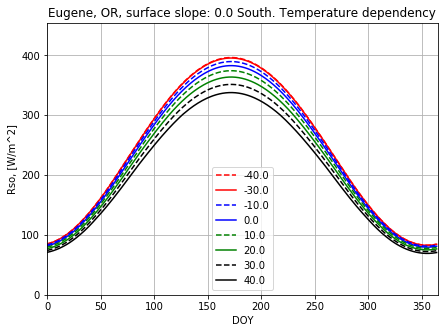

In [18]:
ymax = 450
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, surface slope: "+str(slope_deg)+orient+ "Temperature dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k')
labloc = ("upper left","lower center", "upper center")

fig1, ax1 = plt.subplots(figsize=(7, 5))

temperature_array = [-40.0, -30.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]
i=0
for temperature in temperature_array:
    result = run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity, '1-hour')
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, str(temperature), colors[i],labloc[1])
    i+=1
plt.show()

# ymax = 120
# ymin = -10
# yname = 'NetLW, [W/m^2]'
# xname = 'DOY'
# i=0
# fig2, ax2 = plt.subplots(figsize=(7, 5))
# for temperature in temperature_array:
#     result = run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity,'3-hour','asce-ewri')
# #     print(result[4])
#     plot_results(result[0], result[4], fig2, ax2, ymax, xname, yname, plotname, str(temperature), colors[i],labloc[1],ymin) # 1h
# #     print(result[4])
#     i+=1
# plt.show()
# ymax = 120
# ymin = -10
# yname = 'NetLW, [W/m^2]'
# xname = 'DOY'
# i=0
# fig2, ax2 = plt.subplots(figsize=(7, 5))
# for temperature in temperature_array:
#     result = run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity,'instant','asce-ewri')
# #     print(result[4])
#     plot_results(result[0], result[4], fig2, ax2, ymax, xname, yname, plotname, str(temperature), colors[i],labloc[1],ymin) # 1h
# #     print(result[4])
#     i+=1
# plt.show()
# # #
# ymax = 120
# ymin = -10
# yname = 'NetLW, [W/m^2]'
# xname = 'DOY'
# i=0
# fig2, ax2 = plt.subplots(figsize=(7, 5))
# for temperature in temperature_array:
#     result = run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity,'24-hour','asce-ewri')
# #     print(result[4])
#     plot_results(result[0], result[4], fig2, ax2, ymax, xname, yname, plotname, str(temperature), colors[i],labloc[1],ymin) # 1h
# #     print(result[4])
#     i+=1
# plt.show()


### Slope dependency

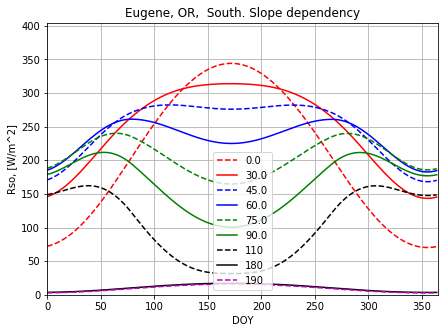

In [19]:
slope_array = [0.0, 30.0, 45.0, 60.0, 75.0, 90.0, 110, 180, 190]
ymax = 400
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, "+orient+ "Slope dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k', 'm--', 'm')
labloc = ("upper left","lower center", "upper center")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for slope in slope_array:
    result = run_radiation(latitude_deg, slope, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity,'24-hour')
    # plot_results.plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, labels[0], colors[0])  # 1h
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, str(slope), colors[i],labloc[1]) # 1h
    # colors = ('b--','b')
    # plot_results.plot_results(result[0],result[3],result[4], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 3h
    # colors = ('k--','k')
    # plot_results.plot_results(result[0],result[5],result[6], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 24h
    i+=1
plt.show()

## Aspect dependency

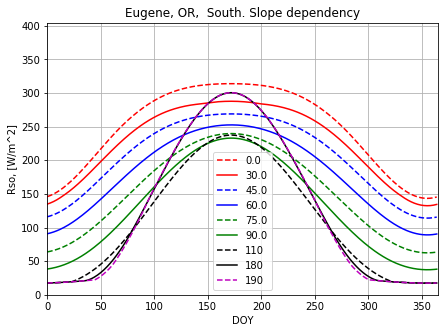

In [22]:
aspect_array = [0.0, 30.0, 45.0, 60.0, 75.0, 90.0, 110, 180, 190]
slope = 30.0 # aspect is only affected when slope not zero ))
ymax = 400
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, "+orient+ "Slope dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k', 'm--', 'm')
labloc = ("upper left","lower center", "upper center")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for aspect in aspect_array:
    result = run_radiation(latitude_deg, slope, aspect, elevation, albedo, turbidity, temperature, rhumidity,'24-hour')
    # plot_results.plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, labels[0], colors[0])  # 1h
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, str(aspect), colors[i],labloc[1]) # 1h
    # colors = ('b--','b')
    # plot_results.plot_results(result[0],result[3],result[4], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 3h
    # colors = ('k--','k')
    # plot_results.plot_results(result[0],result[5],result[6], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 24h
    i+=1
plt.show()

### Latitude dependency

In [ ]:
lat_array = [0.0, 30.0, 45.0, 60.0, 75.0, 90.0]
slope_deg = 0.0
aspect_deg = 60.0
ymax = 450
ymin = -20
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Surface slope: "+str(slope_deg)+orient+ "Latitude dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m','y--','y')
labloc = ("upper left","lower center", "upper center")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for lat in lat_array:
    result = run_radiation(lat, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity,'24-hour')
    # plot_results.plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, labels[0], colors[0])  # 1h
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, str(lat), colors[i],labloc[1],ymin) # 1h
    # colors = ('b--','b')
    # plot_results.plot_results(result[0],result[3],result[4], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 3h
    # colors = ('k--','k')
    # plot_results.plot_results(result[0],result[5],result[6], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 24h
    i+=1
plt.show()

### RHumidity dependency

In [ ]:
rhumidity_array = [0.0, 20.0, 30.0, 40.0,50.0, 60.0, 70.0,80.0, 90.0, 100.0]
slope_deg = 90.0
aspect_deg = 0.0
ymax = 450
ymin = -20
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, surface slope: "+str(slope_deg)+orient+ "Rhumidity dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m','y--','y')
labloc = ("upper left","lower center", "upper center","lower left")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for rhum in rhumidity_array:
    result = run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhum, '24-hour')
    # plot_results.plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, labels[0], colors[0])  # 1h
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, str(rhum), colors[i],labloc[1],ymin) # 1h
    # colors = ('b--','b')
    # plot_results.plot_results(result[0],result[3],result[4], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 3h
    # colors = ('k--','k')
    # plot_results.plot_results(result[0],result[5],result[6], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 24h
    i+=1
plt.show()

### Elevation dependency

In [ ]:
elevation_array = [-100.0, -20.0,0.0, 20.0, 100.0,400.0, 600.0, 800.0, 1000.0, 1800.0, 5000.0, 8800.0]
slope_deg = 90.0
ymax = 350
ymin = -20
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, surface slope: "+str(slope_deg)+orient+ "Elevation dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m','y--','y')
labloc = ("upper left","lower center", "upper center","lower left")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for elev in elevation_array:
    result = run_radiation(latitude_deg, slope_deg, aspect_deg, elev, albedo, turbidity, temperature, rhumidity, '24-hour')
    # plot_results.plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, labels[0], colors[0])  # 1h
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, str(elev), colors[i],labloc[3],ymin) # 1h
    # colors = ('b--','b')
    # plot_results.plot_results(result[0],result[3],result[4], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 3h
    # colors = ('k--','k')
    # plot_results.plot_results(result[0],result[5],result[6], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 24h
    i+=1
plt.show()

### Albedo dependency

In [ ]:
albedo_array = [0.01, 0.05, 0.1, 0.25, 0.5, 0.99]
slope_deg = 60.0
ymax = 700
ymin = -20
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, surface slope: "+str(slope_deg)+orient+ "Albedo dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m','y--','y')
labloc = ("upper left","lower center", "upper center","lower left")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for albedo in albedo_array:
    result = run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity,'24-hour')
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, str(albedo), colors[i],labloc[3],ymin) # 1h
    i+=1
plt.show()


### Turbidity dependency

In [ ]:
turbidity_array = [0.01, 0.05, 0.1, 0.25, 0.5, 1.0]
slope_deg = 0.0
ymax = 450
ymin = -20
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, surface slope: "+str(slope_deg)+orient+ "Turbidity dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m','y--','y')
labloc = ("upper left","lower center", "upper center","lower left")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for turbidity in turbidity_array:
    result = run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity, '24-hour')
    # plot_results.plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, labels[0], colors[0])  # 1h
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, str(turbidity), colors[i],labloc[0],ymin) # 1h
    # colors = ('b--','b')
    # plot_results.plot_results(result[0],result[3],result[4], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 3h
    # colors = ('k--','k')
    # plot_results.plot_results(result[0],result[5],result[6], fig1, ax1, ymax, xname, yname, plotname, labels, colors[i]) # 24h
    i+=1
plt.show()

### Time-step verification of algorithm

In [ ]:
# slope_array = [0.0, 10.0, 30.0, 45.0, 60.0,75.0, 90.0]
slope_array = [60.0]
slope_deg = 60.0
aspect_deg = 180.0
orient=" South. "
if aspect_deg>=180:
    orient=" North. "
ymax = 350
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, "+"Slope: " + str(slope_deg) + orient
labels = ('Ra','Rso')

colors1 = ('r--','k--','b--', 'y--','g--')
colors = ('r','k','b','y','g')
labloc = ("upper left","lower center","upper left", "lower center", "upper center")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for slope in slope_array:
    result = run_radiation(latitude_deg, slope, aspect_deg, elevation, albedo, turbidity, temperature,rhumidity, '1-hour')
    plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, 'Ra-1h', colors1[1],labloc[2])
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, 'Rso-1h', colors[1],labloc[2])
    result = run_radiation(latitude_deg, slope, aspect_deg, elevation, albedo, turbidity, temperature,
                                         rhumidity, '3-hour')
    plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, 'Ra-3h', colors1[2],
                              labloc[2])
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, 'Rso-3h', colors[2],
                              labloc[2])
    result = run_radiation(latitude_deg, slope, aspect_deg, elevation, albedo, turbidity, temperature,
                                         rhumidity, '24-hour')
    plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, 'Ra-24h', colors1[3],
                              labloc[2])
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, 'Rso-24h', colors[3],
                              labloc[2])
    result = run_radiation(latitude_deg, slope, aspect_deg, elevation, albedo, turbidity, temperature,
                                         rhumidity, 'instant')
    plot_results(result[0], result[1], fig1, ax1, ymax, xname, yname, plotname, 'Ra-inst', colors1[0],
                              labloc[2])
    plot_results(result[0], result[2], fig1, ax1, ymax, xname, yname, plotname, 'Rso-inst', colors[0],
                              labloc[2])
    i+=1
plt.show()

### Random inputs

In [ ]:
import random

number_of_trials = 1000


ymax = 900
ymin = -200
yname = 'Rso, [W/m^2]'
xname = 'DOY'
plotname = "Eugene, OR, surface slope: "+str(slope_deg)+orient+ "Turbidity dependency"
labels = ('Ra','Rso')
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m','y--','y')
labloc = ("upper left","lower center", "upper center","lower left")

fig1, ax1 = plt.subplots(figsize=(7, 5))
i = 0
for c in range(1,number_of_trials):
    slope_deg = random.uniform(0.0,360.0)
    aspect_deg = random. uniform(0.0,360.0)
    latitude_deg = random.uniform(0.0,90.0)
    elevation = random.uniform(0.0,8800.0)
    rsm = random.uniform(0.0,1367.0)
    color_id = random.randint(0,11)
    result = run_radiation(latitude_deg, slope_deg, aspect_deg, elevation, albedo, turbidity, temperature, rhumidity, '24-hour', )
    ax1.plot(result[0], result[2], colors[color_id])
    ax1.set_ylabel(yname)
    ax1.set_xlabel(xname)
    plt.title(plotname)
    plt.axis([0, 365, ymin, int(ymax*1.01)])
    plt.grid(True)
    i+=1
plt.show()